In [1]:
from nnsight import LanguageModel
from typing import List, Callable
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

clear_output()

from nnsight import CONFIG

In [2]:
# Load llama3.1
llama = LanguageModel("meta-llama/Meta-Llama-3.1-8B",device="cuda")
llama

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

In [3]:
# All we need to specify using NDIF vs executing locally is remote=True.
with llama.trace("The Eiffel Tower is in the city of", remote=True) as runner:

    hidden_states = llama.model.layers[-1].output.save()

    output = llama.output.save()
    t1_tokens_out = llama.lm_head.output.argmax(dim=-1).save()

print(hidden_states)

print(output["logits"])
print(t1_tokens_out)
print("Original Prediction: ", llama.tokenizer.decode(t1_tokens_out[0][-1]))

2024-10-23 22:02:16,177 c530dd2c-00bf-465f-9b6a-77b3c005ad9b - RECEIVED: Your job has been received and is waiting approval.
2024-10-23 22:02:16,217 c530dd2c-00bf-465f-9b6a-77b3c005ad9b - APPROVED: Your job was approved and is waiting to be run.
2024-10-23 22:02:16,232 c530dd2c-00bf-465f-9b6a-77b3c005ad9b - RUNNING: Your job has started running.
2024-10-23 22:02:16,483 c530dd2c-00bf-465f-9b6a-77b3c005ad9b - COMPLETED: Your job has been completed.


(tensor([[[ 1.7734,  2.6875,  0.8047,  ..., -1.8594,  2.2344,  3.2812],
         [ 0.0352, -0.0430, -2.8750,  ..., -0.8906, -0.0508,  1.6094],
         [ 1.3594, -2.0469,  1.6953,  ..., -1.6875, -0.7539,  1.4297],
         ...,
         [ 1.0078,  0.3125, -0.2852,  ..., -0.0830, -0.2471,  0.2217],
         [ 0.4824, -0.3555,  0.2188,  ...,  0.7422, -0.0078,  0.1133],
         [-0.0557, -0.3652,  0.4648,  ...,  0.9688,  0.6719, -0.8789]]],
       dtype=torch.bfloat16), DynamicCache())
tensor([[[ 6.3438,  8.3750, 12.8125,  ..., -4.3750, -4.3750, -4.3750],
         [-2.4531, -1.7031, -2.0000,  ..., -9.1250, -9.1250, -9.1250],
         [ 9.6875,  4.5938,  5.8750,  ..., -3.3906, -3.3906, -3.3906],
         ...,
         [ 2.3281,  1.0312, -0.3301,  ..., -7.1562, -7.1562, -7.1562],
         [11.2500,  6.0312,  4.9062,  ..., -3.5000, -3.5000, -3.5000],
         [ 8.0625,  5.2500,  4.3750,  ..., -3.9531, -3.9531, -3.9531]]])
tensor([[14924,   220, 10426,   301, 22703,   374,   264, 12366,  409

In [4]:
import torch.nn.functional as F
import numpy as np
def run_lens(model,PROMPT):
    logit_lens_token_result_by_layer = []
    logit_lens_probs_by_layer = []
    logit_lens_ranks_by_layer = []
    input_ids = model.tokenizer.encode(PROMPT)
    with model.trace(input_ids, remote=True) as runner:
        for layer_ix,layer in enumerate(model.model.layers):
            hidden_state = layer.output[0][0]
            logit_lens_normed_last_token = model.model.norm(hidden_state)
            logit_lens_token_distribution = model.lm_head(logit_lens_normed_last_token)
            logit_lens_last_token_logit = logit_lens_token_distribution[-1:]
            logit_lens_probs = F.softmax(logit_lens_last_token_logit, dim=1).save()
            logit_lens_probs_by_layer.append(logit_lens_probs)
            logit_lens_next_token = torch.argmax(logit_lens_probs, dim=1).save()
            logit_lens_token_result_by_layer.append(logit_lens_next_token)
        tokens_out = llama.lm_head.output.argmax(dim=-1).save()
        expected_token = tokens_out[0][-1].save()
    # logit_lens_all_probs = np.concatenate([probs[:, expected_token].cpu().detach().numpy() for probs in logit_lens_probs_by_layer])
    logit_lens_all_probs = np.concatenate([probs[:, expected_token].cpu().detach().to(torch.float32).numpy() for probs in logit_lens_probs_by_layer])

    #get the rank of the expected token from each layer's distribution
    for layer_probs in logit_lens_probs_by_layer:
        # Sort the probabilities in descending order and find the rank of the expected token
        sorted_probs, sorted_indices = torch.sort(layer_probs, descending=True)
        # Find the rank of the expected token (1-based rank)
        expected_token_rank = (sorted_indices == expected_token).nonzero(as_tuple=True)[1].item() + 1
        logit_lens_ranks_by_layer.append(expected_token_rank)
    print("logit_lens_ranks_by_layer: ", logit_lens_ranks_by_layer)
    actual_output = llama.tokenizer.decode(expected_token.item())
    logit_lens_results = [model.tokenizer.decode(next_token.item()) for next_token in logit_lens_token_result_by_layer]
    return logit_lens_results, logit_lens_all_probs, actual_output,logit_lens_ranks_by_layer

In [5]:
PROMPT = "The Eiffel Tower is in the city of"
logit_lens_results, logit_lens_all_probs, actual_output,logit_lens_ranks_by_layer = run_lens(llama,PROMPT)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
2024-10-23 22:02:17,044 d4ebb16c-9e83-4ce5-8266-c5131fd8ddc9 - RECEIVED: Your job has been received and is waiting approval.
2024-10-23 22:02:17,080 d4ebb16c-9e83-4ce5-8266-c5131fd8ddc9 - APPROVED: Your job was approved and is waiting to be run.
2024-10-23 22:02:17,091 d4ebb16c-9e83-4ce5-8266-c5131fd8ddc9 - RUNNING: Your job has started running.
2024-10-23 22:02:17,424 d4ebb16c-9e83-4ce5-8266-c5131fd8ddc9 - COMPLETED: Your job has been completed.


logit_lens_ranks_by_layer:  [19008, 26738, 7799, 7017, 1908, 3173, 5821, 19250, 10591, 49139, 38376, 10856, 10742, 10129, 1691, 418, 7, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [6]:
logit_lens_results

['Looper',
 'oley',
 '内の',
 '内の',
 ' en',
 ' Oaks',
 ' Oaks',
 'allis',
 ' entr',
 'uzu',
 '�',
 ')frame',
 ')frame',
 ' Vend',
 'oplevel',
 'undler',
 'undler',
 ' Paris',
 ' _______,',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris',
 ' Paris']

In [7]:
logit_lens_all_probs

array([7.9274178e-06, 4.1127205e-06, 1.8715858e-05, 2.2053719e-05,
       7.3909760e-05, 4.9114227e-05, 2.7060509e-05, 6.8843365e-06,
       1.4543533e-05, 1.7881393e-06, 2.7567148e-06, 1.4841557e-05,
       1.5854836e-05, 1.6212463e-05, 8.3446503e-05, 2.5177002e-04,
       3.4942627e-03, 3.1738281e-02, 2.2583008e-02, 2.5781250e-01,
       7.4609375e-01, 8.5937500e-01, 9.1015625e-01, 9.4921875e-01,
       9.8046875e-01, 9.8046875e-01, 9.8437500e-01, 9.8437500e-01,
       9.7656250e-01, 9.8828125e-01, 9.8828125e-01, 8.9453125e-01],
      dtype=float32)

/mnt/ssd/aryawu/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20869 (\N{CJK UNIFIED IDEOGRAPH-5185}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/ssd/aryawu/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


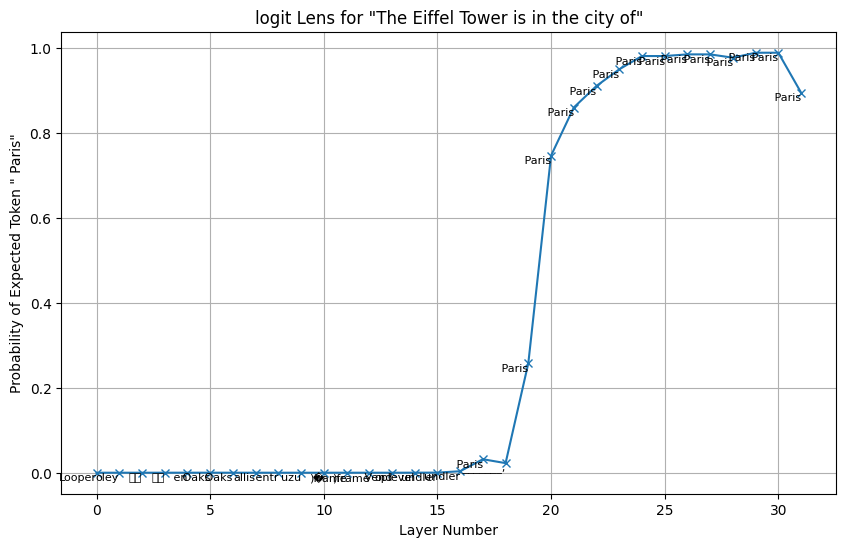

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
def plot__lens(logit_lens_all_probs,logit_lens_results,actual_output):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(logit_lens_all_probs)), logit_lens_all_probs, marker='x')

    for layer_number, next_token in enumerate(logit_lens_results):
        plt.text(layer_number, logit_lens_all_probs[layer_number], next_token, ha='right', va='top',fontsize=8)

    plt.xlabel('Layer Number')
    plt.ylabel(f'Probability of Expected Token "{actual_output}"')
    plt.title(f'logit Lens for "{PROMPT}"')
    plt.grid(True)
    plt.show()

plot__lens(logit_lens_all_probs,logit_lens_results,actual_output)

In [9]:
def plot_rank(logit_lens_ranks_by_layer):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(logit_lens_ranks_by_layer)), logit_lens_ranks_by_layer, marker='x')
    for layer_number, rank in enumerate(logit_lens_ranks_by_layer):
        plt.text(layer_number, rank, rank, ha='right', va='top',fontsize=8)
    plt.xlabel('Layer Number')
    plt.ylabel('Rank of Expected Token')
    plt.title(f'Rank of Expected Token "{actual_output}"')
    plt.grid(True)
    plt.show()

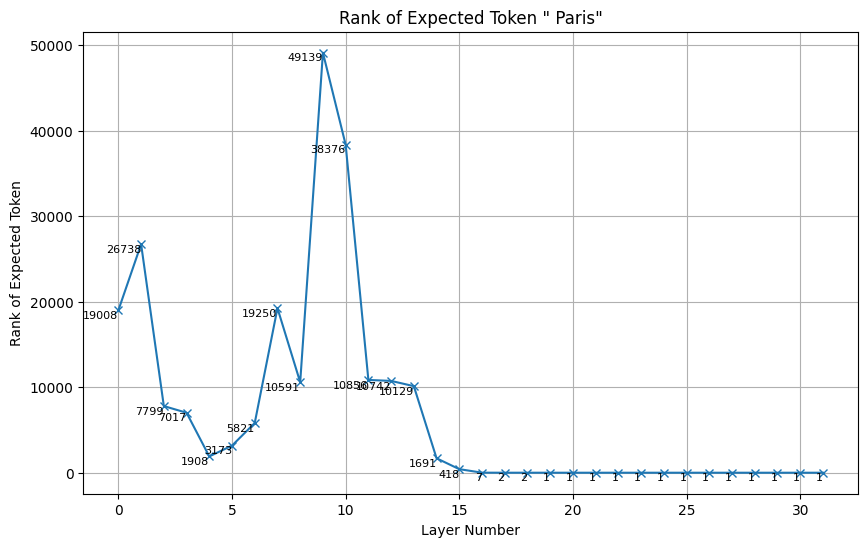

In [10]:
plot_rank(logit_lens_ranks_by_layer)